In [17]:
from climada.hazard import TCTracks

# Trying to modify Hurricane Matthew's track

2025-03-14 15:38:50,018 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file /home/aesgeorges/climada/data/IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.


<GeoAxes: >

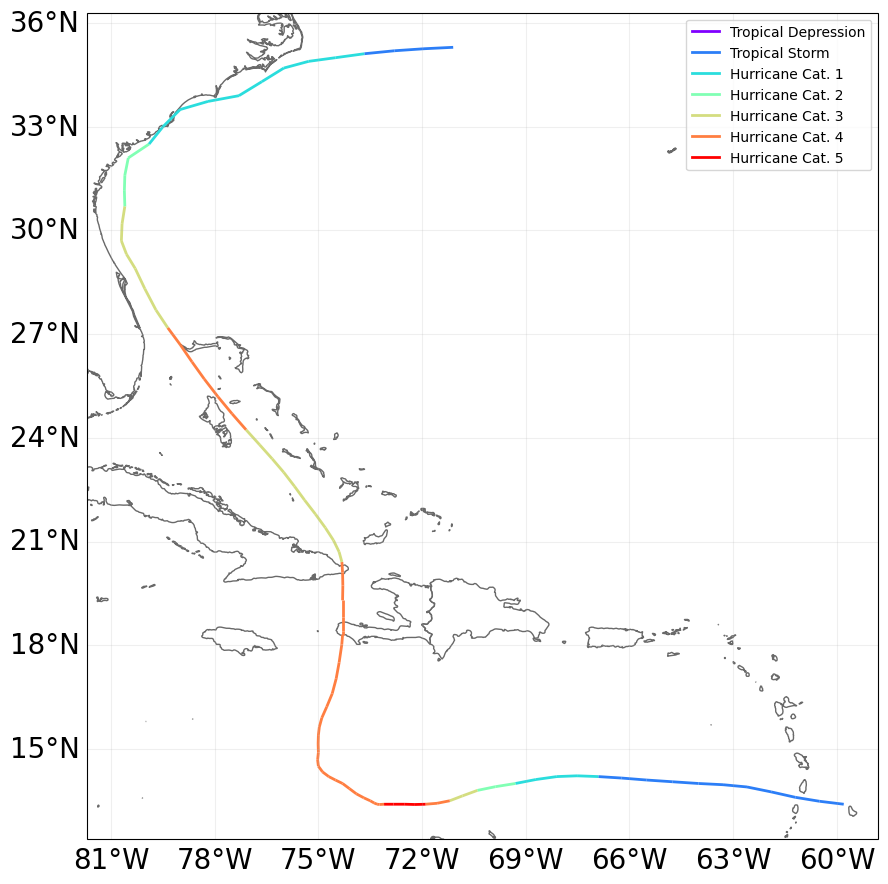

In [18]:
track_id = ['2016273N13300']
matthew = TCTracks.from_ibtracs_netcdf(provider='usa', storm_id=track_id[0], estimate_missing=True)
matthew.plot()

In [19]:
from shapely.geometry import LineString
import geopandas as gpd

lat = matthew.data[0].lat
lon = matthew.data[0].lon

# Create the line geometry from coordinates
coords = list(zip(lon, lat))  # GIS coordinates are (lon, lat)
line = LineString(coords)

# Create a GeoDataFrame with the track
gdf = gpd.GeoDataFrame({'name': ['Matthew']}, 
                       geometry=[line], 
                       crs="EPSG:4326")
gdf.to_file('exports/matthew.shp')

<GeoAxes: >

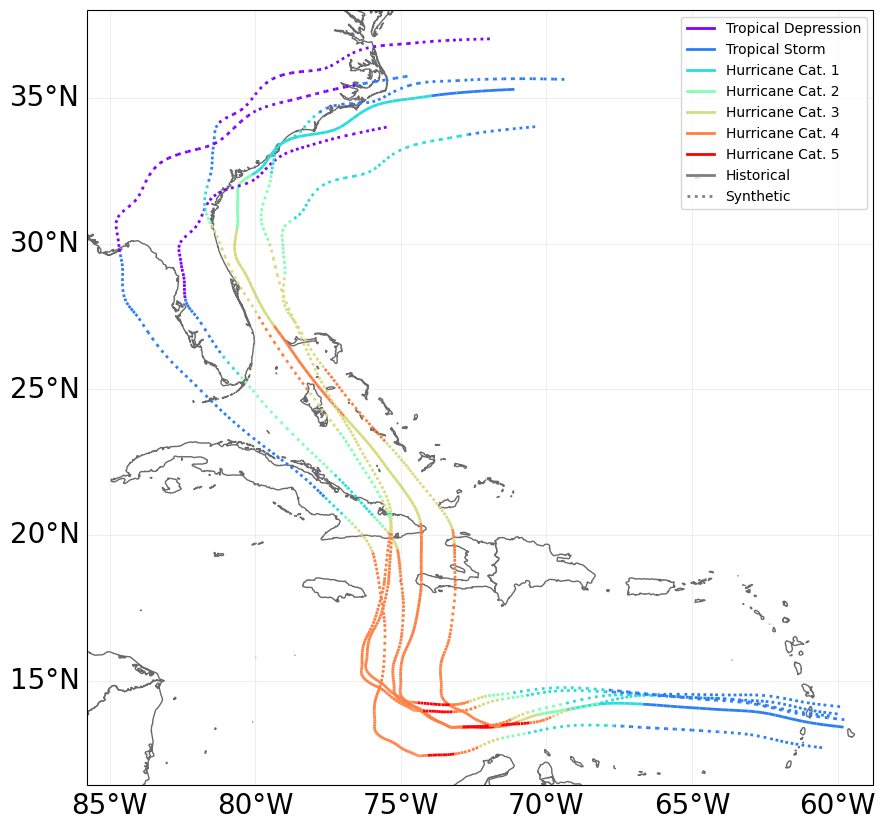

In [ ]:
# Generate synthetic tracks
matthew.equal_timestep()
matthew.calc_perturbed_trajectories(nb_synth_tracks=5)
matthew.plot()

In [21]:
pd = matthew.to_geodataframe()
pd

,max_sustained_wind_unit,central_pressure_unit,orig_event_flag,data_provider,category,name,sid,id_no,geometry
0,kn,mb,True,ibtracs_usa,5,MATTHEW,2016273N13300,2.016273e+12,"LINESTRING (-59.80000 13.40000, -60.03328 13.4..."
1,kn,mb,False,ibtracs_usa,5,MATTHEW_gen1,2016273N13300_gen1,2.016273e+12,"LINESTRING (-59.91972 14.10340, -60.15416 14.1..."
2,kn,mb,False,ibtracs_usa,5,MATTHEW_gen2,2016273N13300_gen2,2.016273e+12,"LINESTRING (-60.00514 13.85207, -60.20942 13.8..."
3,kn,mb,False,ibtracs_usa,5,MATTHEW_gen3,2016273N13300_gen3,2.016273e+12,"LINESTRING (-60.27268 13.78597, -60.47433 13.8..."
4,kn,mb,False,ibtracs_usa,5,MATTHEW_gen4,2016273N13300_gen4,2.016273e+12,"LINESTRING (-59.77258 13.65723, -60.05910 13.6..."
5,kn,mb,False,ibtracs_usa,5,MATTHEW_gen5,2016273N13300_gen5,2.016273e+12,"LINESTRING (-60.53709 12.69449, -60.71971 12.7..."


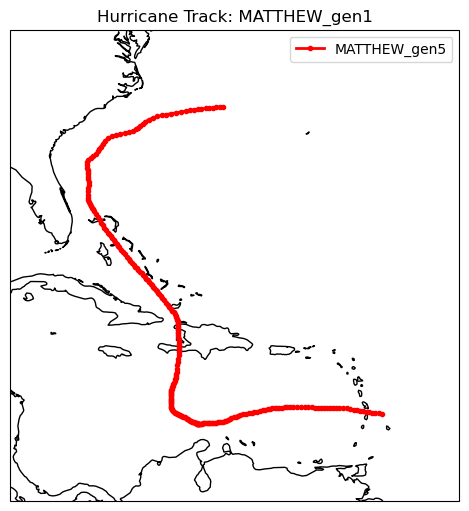

In [39]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
fig, ax = plt.subplots(figsize = (8,5), subplot_kw={'projection': ccrs.PlateCarree()}, 
                    constrained_layout=True)
# Add coastlines and land features for reference
ax.coastlines()
id = 1
# Plot the hurricane track (5th synthetic track from the dataset)
track_line = pd.iloc[id]['geometry']
x, y = track_line.xy
ax.plot(x, y, color='red', linewidth=2, marker='o', markersize=3, 
    transform=ccrs.PlateCarree(), label=pd.iloc[5]['name'])

# Add title and legend
plt.title(f"Hurricane Track: {pd.iloc[id]['name']}")
plt.legend()

# Set extent to focus on the track region
bounds = track_line.bounds  # (minx, miny, maxx, maxy)
ax.set_extent([bounds[0]-5, bounds[2]+5, bounds[1]-5, bounds[3]+5], crs=ccrs.PlateCarree())

In [ ]:
import numpy as np
import os

def modify_fort22_with_linestring(fort22_path, linestring, output_path=None):
    """
    Modify hurricane track locations in a fort.22 file using a LineString geometry
    
    Parameters:
    -----------
    fort22_path : str
        Path to the input fort.22 file
    linestring : shapely.geometry.LineString
        LineString containing the new track coordinates
    output_path : str, optional
        Path to save the modified fort.22 file. If None, will use fort22_path + '.modified'
    
    Returns:
    --------
    str
        Path to the modified fort.22 file
    """
    
    if output_path is None:
        output_path = f"{fort22_path}.modified"
    
    # Create the directory if it doesn't exist
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    
    # Extract coordinates from the linestring
    coords = np.array(linestring.coords)
    lons = coords[:, 0]
    lats = coords[:, 1]
    
    # Read the fort.22 file
    with open(fort22_path, 'r') as f:
        lines = f.readlines()
    
    # Parse header to get number of timesteps
    # Be more robust with the header parsing
    header = lines[0].strip().split()
    try:
        num_timesteps = int(header[0])
    except ValueError:
        # Check if this is a specially formatted file (e.g. with storm ID)
        # Try to find the first integer in the header
        for item in header:
            try:
                num_timesteps = int(item)
                break
            except ValueError:
                continue
        
        if 'num_timesteps' not in locals():
            # If we still don't have a number, count the data lines
            num_timesteps = len([line for line in lines[1:] if line.strip()])
    
    # Check if we have enough points in the linestring
    if len(lons) < num_timesteps:
        raise ValueError(f"LineString has {len(lons)} points, but fort.22 has {num_timesteps} timesteps")
    
    # If linestring has more points than needed, subsample it
    if len(lons) > num_timesteps:
        indices = np.round(np.linspace(0, len(lons) - 1, num_timesteps)).astype(int)
        lons = lons[indices]
        lats = lats[indices]
    
    # Create new file with modified coordinates
    with open(output_path, 'w') as f:
        # Write header line
        f.write(lines[0])
        
        # Process each time step line
        data_line_count = 0
        for i in range(1, len(lines)):
            if data_line_count >= num_timesteps:
                # We've processed all data lines, just copy the rest
                f.write(lines[i])
                continue
                
            line = lines[i].strip()
            if not line:  # Skip empty lines
                f.write(lines[i])
                continue
                
            parts = line.split()
            
            # Try to identify which columns contain lat/lon
            # Common formats have lat/lon as columns 5-6 or near the end
            lon_idx = None
            lat_idx = None
            
            # Look for values that could be longitude/latitude
            for j, part in enumerate(parts):
                try:
                    val = float(part)
                    # Longitude is usually in range -180 to 180
                    if -180 <= val <= 180 and lon_idx is None:
                        lon_idx = j
                    # Latitude is usually in range -90 to 90
                    elif -90 <= val <= 90 and lat_idx is None and j != lon_idx:
                        lat_idx = j
                except ValueError:
                    continue
            
            # If we found lon/lat indices, replace them
            if lon_idx is not None and lat_idx is not None and data_line_count < len(lons):
                parts[lon_idx] = f"{lons[data_line_count]:.6f}"
                parts[lat_idx] = f"{lats[data_line_count]:.6f}"
                data_line_count += 1
            
            # Write modified line
            f.write(' '.join(parts) + '\n')
    
    print(f"Modified fort.22 file saved to {output_path}")
    return output_path

# Example usage:
# Select a specific track from the GeoDataFrame
track_geometry = pd.iloc[1].geometry  

try:
    modify_fort22_with_linestring('matthew.22', track_geometry, 'exports/matthew_mod.22')
except FileNotFoundError:
    print("Could not find matthew.22 file. Please make sure the file exists.")
except Exception as e:
    print(f"Error processing file: {e}")

ValueError: invalid literal for int() with base 10: 'AL,'